In [2]:
import numpy as np
import matplotlib.pyplot as plt
import f2py_yldfit as fyf
from scipy.optimize import fsolve, minimize,basinhopping
import yieldfuncs as yf
import crystal_plasticity_module as cp
import yieldfuncs as yf
import odflib
import itertools
import pandas as pd

In [3]:
filename = r'final_results.npz'
with np.load(f'{filename}') as data:
    # all_gs = data['all_gs']
    all_coefs = data['all_coefs']
    all_exps = data['all_exps']
    all_res = data['all_res']
   
all_coefs[:,1:,:] = all_coefs[:,:-1,:]
all_exps[1:,:] = all_exps[:-1,:]
all_res[1:,:] = all_res[:-1,:]

with np.load(r'nullvals.npz') as data:
    all_coefs[:,0,:] = data['all_coefs']
    all_exps[0,:] = data['all_exps']
    all_res[0,:] = data['all_res']


threshold = 4e3  # Set your desired threshold

# Find cases where any residual exceeds the threshold
mask = np.any(all_res > threshold, axis=0)  # Shape: (7, 512) → collapsed to (512)

filtered_coefs = all_coefs[:, :, ~mask]
filtered_exps = all_exps[:, ~mask]
filtered_res = all_res[:, ~mask]

# Print new shapes to verify
# Get indices of removed cases
removed_indices = np.where(mask==True)[0]  # Extract indices where mask is True
valid_case_indices = np.where(mask==False)[0]  # Extract indices where mask is True

# Print or store them
print("Removed case indices:", removed_indices)
print("Removed case indices:", [oct(index)[2:] for index in removed_indices])
print(filtered_coefs.shape)  # Should be (18, 7, fewer cases)
print(filtered_exps.shape)   # Should be (7, fewer cases)
print(filtered_res.shape)    # Should be (7, fewer cases)


Removed case indices: []
Removed case indices: []
(18, 7, 512)
(7, 512)
(7, 512)


In [4]:

# Define phi and epsilon (adjust these to your actual data)
phi_values = np.linspace(0,2*np.pi, 9)[:-1]  # Example: angles from 0 to π
epsilon_values = np.ones_like(phi_values) * 0.25  # Example: constant strain increment

# Extract 16 coefficients for the current strain increment (input)
coefs_16_input = filtered_coefs[2:, :-1, :]  # Shape: (16, 6, N)

# Extract the exponent for the current strain increment (input)
exp_input = filtered_exps[:-1, :]  # Shape: (6, N)

# Extract 16 coefficients for the next strain increment (target)
coefs_16_target = filtered_coefs[2:, 1:, :]  # Shape: (16, 6, N)

# Extract the exponent for the next strain increment (target)
exp_target = filtered_exps[1:, :]  # Shape: (6, N)

# Reshape all arrays into 2D for CSV storage
coefs_16_input_flat = coefs_16_input.reshape(16, -1).T  # Shape: (6*N, 16)
exp_input_flat = exp_input.reshape(-1, 1)  # Shape: (6*N, 1)
coefs_16_target_flat = coefs_16_target.reshape(16, -1).T  # Shape: (6*N, 16)
exp_target_flat = exp_target.reshape(-1, 1)  # Shape: (6*N, 1)

# Repeat phi and epsilon to match input shape
phi_repeated = np.repeat(phi_values, 6).reshape(-1, 1)  # Shape: (6*N, 1)
epsilon_repeated = np.repeat(epsilon_values, 6).reshape(-1, 1)  # Shape: (6*N, 1)

# Convert case indices (0 to 511) to octal strings (always 3 digits with leading zeros)
case_indices = np.arange(512)  # Assuming 512 cases in total
octal_strings = np.array([f"{idx:o}".zfill(3) for idx in case_indices])  # Format as 3-digit octal

# Define function to get the correct phi index based on strain index
def get_phi_index(strain_index, octal_string):
    if strain_index in [0, 1]:  # Use first octal digit
        return int(octal_string[0])
    elif strain_index in [2, 3]:  # Use second octal digit
        return int(octal_string[1])
    elif strain_index in [4, 5]:  # Use third octal digit
        return int(octal_string[2])

# Generate phi values for all cases and strain increments
phi_per_case = np.zeros((6, 512))  # 6 strain increments per case
for strain_idx in range(6):
    phi_per_case[strain_idx, :] = [phi_values[get_phi_index(strain_idx, octal_strings[i])] for i in range(512)]

# Now filter phi values based on removed cases
phi_filtered = phi_per_case[:, valid_case_indices]  # Keep only valid cases

# Reshape phi to match the final dataset format
phi_repeated = phi_filtered.reshape(-1, 1)  # Shape: (6*N, 1)

# Epsilon remains constant or varies (set accordingly)
epsilon_repeated = np.ones_like(phi_repeated) * 0.1  # Adjust as needed

# Now, include this updated `phi_repeated` in the dataset
df = pd.DataFrame(np.column_stack([coefs_16_input_flat, exp_input_flat, phi_repeated, epsilon_repeated, coefs_16_target_flat, exp_target_flat]),
                  columns=[f'coef_{i+3}' for i in range(16)] + 
                          ['exp_input', 'phi', 'epsilon'] + 
                          [f'next_coef_{i+3}' for i in range(16)] + 
                          ['exp_target'])

df.to_csv("filtered_data.csv", index=False)
print("CSV saved successfully!")


CSV saved successfully!


In [10]:
case = 107
L_combination = int(oct(case)[2:])
print(all_res[:,case],L_combination)

[269.62141182 307.93673306 337.66700334 311.91002278 272.48619581
 316.40360658 463.66125073] 153


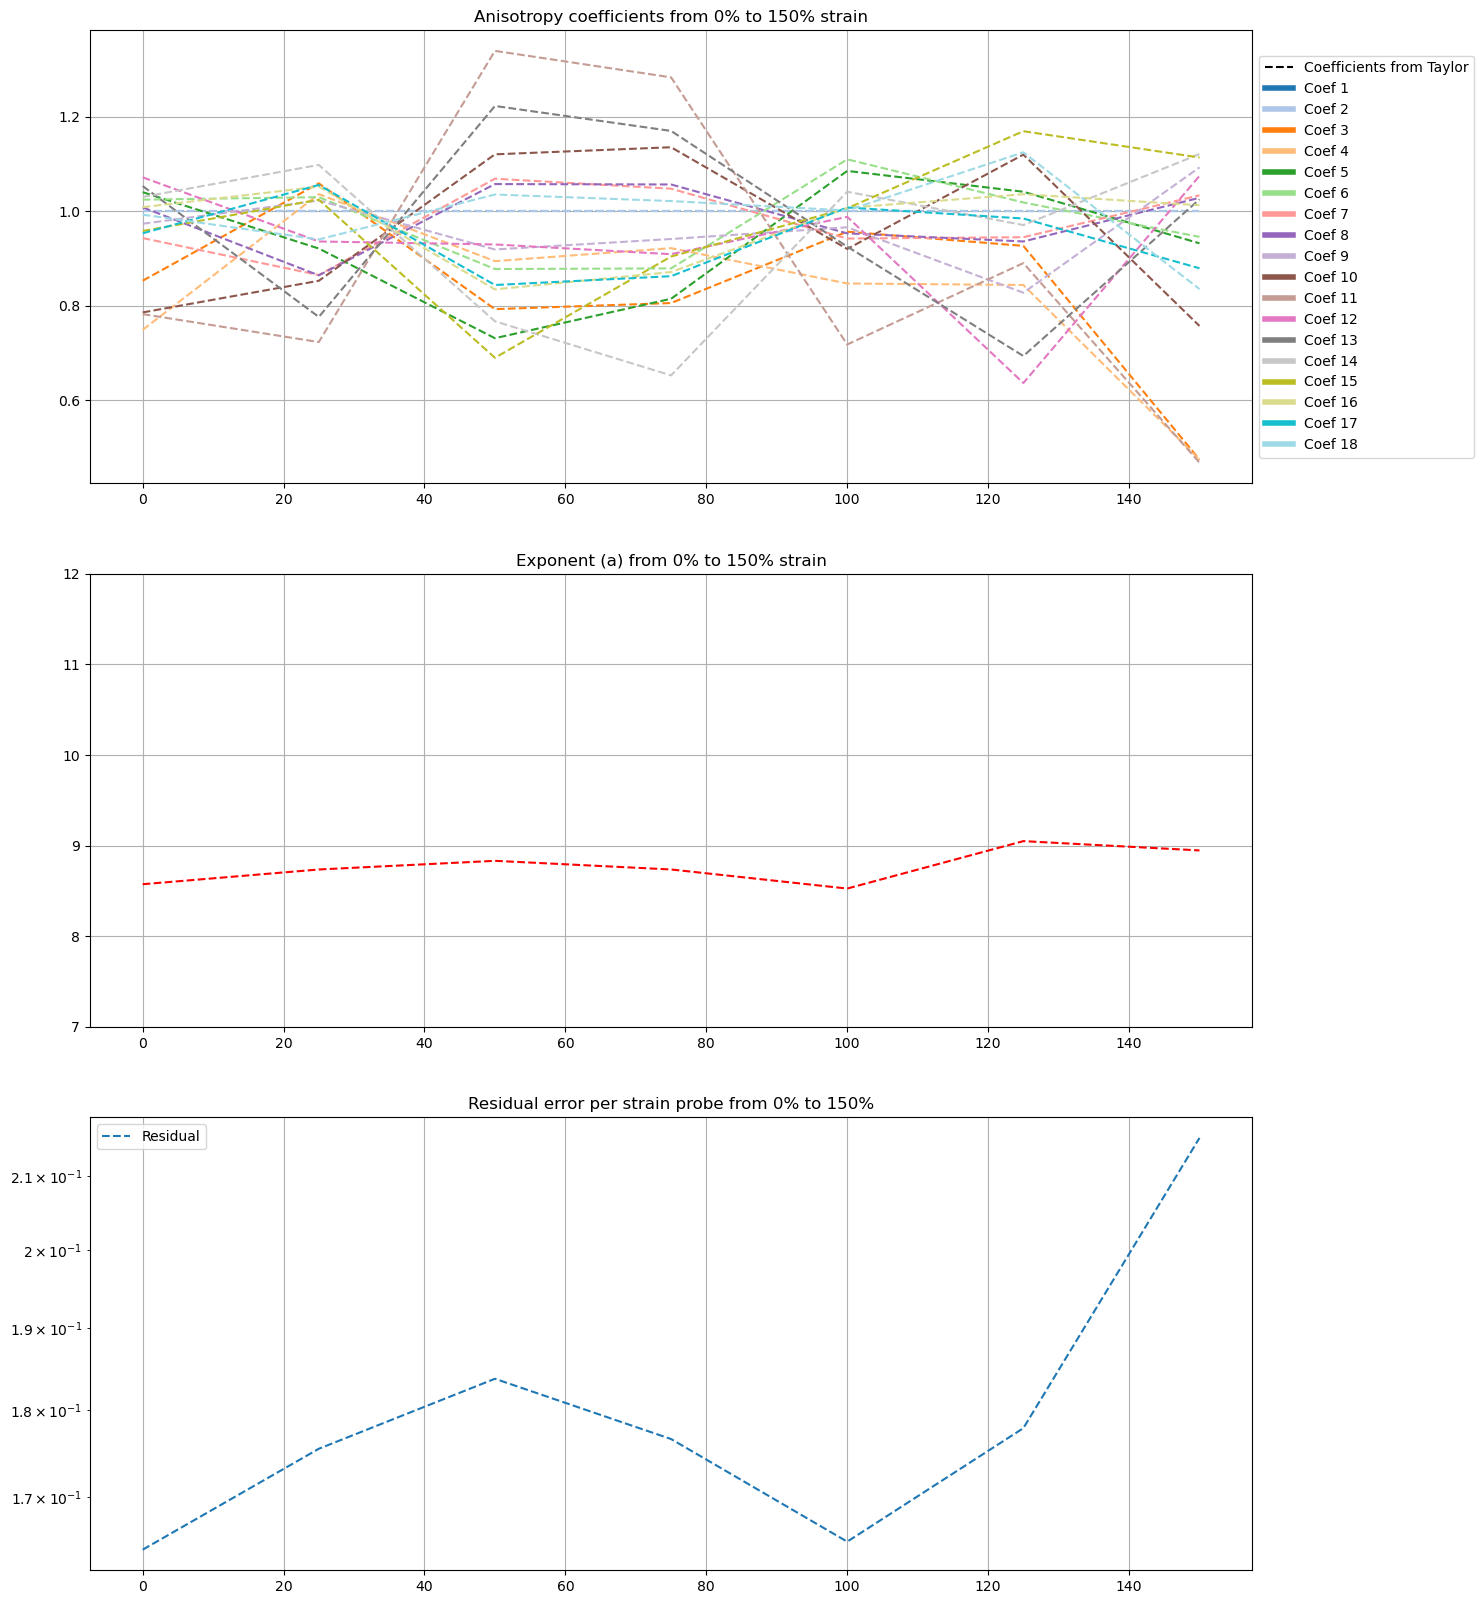

463.6612507259415


In [11]:
from matplotlib.gridspec import GridSpec
fig = plt.figure(figsize=(15, 20),constrained_layout=True)

gs = GridSpec(3, 1, height_ratios=[1, 1,1])  # Two rows, two columns
ax1 = fig.add_subplot(gs[0, 0])  # Top-left
ax2 = fig.add_subplot(gs[1, 0])  # Top-right
ax3 = fig.add_subplot(gs[2, 0])
axs =[ax1,ax2,ax3]
strains = [0,25,50,75,100,125,150]
colors = plt.cm.tab20(np.linspace(0, 1, all_coefs.shape[0]))

legend_elements = [
    plt.Line2D([0], [0], color='k', linestyle='--', label=f'Coefficients from Taylor'),
] 
for i in range(18): 
    legend_elements.append(plt.Line2D([0],[0],color=colors[i],linewidth=4,label=f'Coef {i+1}'))

for i in range(all_coefs.shape[0]):
    ax1.plot(strains, all_coefs[i,:,case], '--', label=f'Coef {i+1}',color=colors[i])
    

for ax in axs: ax.grid()
ax2.plot(strains,all_exps[:,case],'--r',label ='Taylor')

ax3.plot(strains,np.sqrt(all_res[:,case]/1e4), '--', label = 'Residual')
ax3.legend()

ax1.set_title('Anisotropy coefficients from 0% to 150% strain')
ax2.set_title('Exponent (a) from 0% to 150% strain')
ax3.set_title('Residual error per strain probe from 0% to 150%')

ax1.legend(loc="center left", bbox_to_anchor=(1, 0.5),handles=legend_elements)

# ax1.set_ylim(-1,2)
ax2.set_ylim(7,12)
ax3.set_yscale('log')


""" if not os.path.exists(f'{save_path}'):
    plt.savefig(save_path, dpi=300)
else: 
    print('Check if you are overwriting your files') """
plt.show()
print(all_res[-1,case])

In [10]:
elasticity = None
# choose the crystallography of the grains
crystal_structure = 'FCC_111'
grain_interaction = 'FCTAYLOR'   # Taylor model without grain interactions
hardening_law = {'model'                : 'RIGID_PLASTIC',    # rigid plasticity with a given critical stress
                 'hardening_parameters' : [10.],              # CRSS [MPa]
                 'relax_penalties'      : [0., 0., 0.]}       # [MPa]
S_direction = None
# prescribed absolute stress components
S_absolute = None

# bool array for indicating known (True) and unknown (False) terms in both vel. gradient and stress tensor
iL = True
iS_direction = False
iS_absolute = False
# number of computation steps
Nsteps = 25
# time increment
dt = 0.01
# run with elasticity or without
run_elasticity = False
# set export options
results_output_options = {'grain_results'       : ['euler_angles','sliprates','crss','relaxation','stress_loc'],
                          'polycrystal_results' : ['average_stress','average_slip'],
                          'number_of_outputs'   : Nsteps}
dofortran = True

In [11]:
def create_L_array(num_of_Ls, start=0, end=2*np.pi):
    thetas = np.linspace(start, end, num_of_Ls)
    L_array = np.zeros((3, 3, num_of_Ls))  # Initialize the 3x3xn array

    for i, theta in enumerate(thetas):
        diag_values = np.array([np.cos(theta), np.sin(theta), -np.cos(theta) - np.sin(theta)])
        vonMisesNorm = np.sqrt(2/3) * np.linalg.norm(diag_values)
        diag_values /= vonMisesNorm  # Normalize

        L = np.zeros((3, 3))  # Create the 3x3 tensor
        L[0, 0] = diag_values[0]
        L[1, 1] = diag_values[1]
        L[2, 2] = diag_values[2]

        L_array[:, :, i] = L  # Store in the array

    return L_array[:,:,:-1]

def yield_loci_2d(i,j,k, strain):
    gradients = create_L_array(9, 0, 2*np.pi)
    combination = tuple(np.where(abs(matrix) < 1e-6, 0, matrix) for matrix in (gradients[:, :, i], gradients[:, :, j], gradients[:, :, k]))

    orientations = {}
    orientations['grains'] = np.loadtxt(r'Rand1000.tex', skiprows=4, usecols=(0,1,2))
    polycrystal = cp.Polycrystal(crystal_structure, orientations, elasticity, hardening_law, grain_interaction)
        
    cumulative_strain = 0  # Start at 0% strain for each combination

    for L in combination:
        for step in range(2):  # Each L should do 2 steps (25% increments)
            if cumulative_strain == strain:
                YL, R, non_converg_stress = polycrystal.yield_locus(locus_type='2D', number_of_points=100, plot_axes=('11','22','12',[0, 5, 10,15]))
                return YL
            
            cumulative_strain += Nsteps  # Increment strain level
            polycrystal.load(L, S_direction, S_absolute, iL, iS_direction, iS_absolute,
                                Nsteps, dt, run_elasticity, results_output_options, dofortran)
            print(f'Texture simulation done ({cumulative_strain}% strain), current gradient: {L}')
    if cumulative_strain == strain:
                YL, R, non_converg_stress = polycrystal.yield_locus(locus_type='2D', number_of_points=100, plot_axes=('11','22','12',[0, 5, 10,15]))
                return YL
            

In [12]:
L_combination = "103"
i, j, k = (int(x) for x in str(L_combination))
print(i,j,k)

1 0 3


In [ ]:
#Generate stresses from fitted yield function and plot yield curves in chosen stress plane
colors = ['r', 'g', 'b', 'm']
fig, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(18, 18), gridspec_kw={'width_ratios': [1, 1, 1]})
legend_elements = [
    plt.Line2D([0], [0], color='k', linestyle='--', label='FC Taylor Model'),
    plt.Line2D([0], [0], color='k', linestyle='None', marker='.', label='YLD2004-18p')
]

plots = [('11','22','12',[0,5,10,15])]

for i, sigma in enumerate(plots[0][3]):
    legend_elements.append(plt.Line2D([0], [0], color=colors[i], linewidth=4, label=r'$\sigma_{12} = $'+ f'{plots[0][3][i]}MPa'))
axs = [ax1,ax2,ax3]
coef= all_coefs[:,0,0]
NT = 1
sigY = 30.
a =  8

model = 'YLD2004_18p'
yfun = {'func':model, 
        'coef':coef, 
        'exp':a, 
        'Ntransf':NT,
        'y0':sigY}



YL1 = yield_loci_2d(i,j,k,0)
YL2 = yield_loci_2d(i,j,k,75)
YL3 = yield_loci_2d(i,j,k,150)

for i in range(len(plots[0][3])):
    coef = all_coefs[:,0,case]
    exp = all_exps[0,case]
    yfun['coef'] = coef
    yfun['exp'] = exp
    gs = yf.genStresses(400, yfun, plot_axes=plots[0], save2file=False)
    ax1.plot(gs[0,0,400*i:400*(i+1)], gs[1,1,400*i:400*(i+1)], "--",color = colors[i])
    ax1.set_title("0% Strain")
    
    coef= all_coefs[:,3,case]
    exp = all_exps[3,case]
    yfun['coef'] = coef
    yfun['exp'] = exp
    gs = yf.genStresses(400, yfun, plot_axes=plots[0], save2file=False) 
    ax2.plot(gs[0,0,400*i:400*(i+1)], gs[1,1,400*i:400*(i+1)], "--",color = colors[i])
    ax2.set_title("75% Strain")

    coef= all_coefs[:,6,case]
    exp = all_exps[6,case]
    yfun['coef'] = coef
    yfun['exp'] = exp
    gs = yf.genStresses(400, yfun, plot_axes=plots[0], save2file=False)
    ax3.plot(gs[0,0,400*i:400*(i+1)], gs[1,1,400*i:400*(i+1)], "--",color = colors[i])
    ax3.set_title("150% Strain")

    ax1.plot(YL1[0,0,100*i:100*(i+1)], YL1[1,1,100*i:100*(i+1)],'.',color = colors[i])

    ax2.plot(YL2[0,0,100*i:100*(i+1)], YL2[1,1,100*i:100*(i+1)],'.',color = colors[i])

    ax3.plot(YL3[0,0,100*i:100*(i+1)], YL3[1,1,100*i:100*(i+1)],'.',color = colors[i])



for ax in axs:
    ax.axhline(0, color='black', linewidth=1)  
    ax.axvline(0, color='black', linewidth=1)
    ax.set_aspect('equal')
    ax.grid(True)
    ax.legend(handles=legend_elements)
    ax.set_ylabel(r'$\sigma_{22}$',fontsize=13)
    ax.set_xlabel(r'$\sigma_{11}$',fontsize=13)

plt.tight_layout()
plt.show()
print(i,j,k)